# Imports

In [120]:
# Systems
import os
import re
import warnings
from dotenv import load_dotenv

# Data Analysis
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from ydata_profiling import ProfileReport

# Database
from sqlalchemy import create_engine

# AI Agent
import google.generativeai as genai
# Optional for Jupyter Notebooks
from IPython.display import Markdown

# Configurations

In [121]:
# Plotting directly
%matplotlib inline

# Load dotenv
load_dotenv()

# Ignore warning messages 
warnings.filterwarnings('ignore')

# For plotting style
plt.style.use('seaborn-v0_8-whitegrid')

# Gemini Model
GEMINI_API_KEY = os.getenv("GEMINI_API_KEY")
genai.configure(api_key=GEMINI_API_KEY)
gemini_model_name='gemini-2.0-flash-exp'
gemini = genai.GenerativeModel(
    model_name=gemini_model_name,
    generation_config=genai.GenerationConfig(temperature=2.0),
)

# Database Parameters
db_params = {
    "host": "127.0.0.1",
    "database": "pinkfong_db",
    "user": "postgres",
    "password": os.environ.get("PASSWORD"),
    "port": "5432",
}
engine = create_engine(
    f'postgresql://{db_params["user"]}:{db_params["password"]}@{db_params["host"]}/{db_params["database"]}'
)

# Check connections

Check that the database connection is working correctly.

In [122]:
try:
    with engine.connect() as connection:
        print("Database connection successful.")
except Exception as e:
    print(f"Error connecting to the database: {e}")
    
engine.dispose()

Database connection successful.


Check that the model is working correctly.

In [123]:
try:
    response = gemini.generate_content("Respond any single word.")
    if response and response.text:
        print("Model is operational and returned a response.")
    else:
        print("Model returned an empty response.")
except Exception as e:
    print(f"An error occurred while interacting with the model: {e}")

Model is operational and returned a response.


# Brainstorming with AI

Let's extract the metadata of all kids youtube channels to later get insights on how to get a follow-up of data analysis.

In [124]:
def extract_metadata(df):
    metadata = {}
    
    # Shape of data
    metadata['shape'] = df.shape
    
    # Variable names
    metadata['variables'] = df.columns.tolist()
    
    # Data Types
    metadata['dtypes'] = str(df.dtypes)
    
    # Summary stats
    metadata['sample'] = df.head(1).to_dict(orient='records')
    
    return metadata

In [125]:
query = """
SELECT
    *
FROM video_stats s
JOIN video_metadata m
    ON s.video_id = m.video_id
"""

df = pd.read_sql(query,con=engine)
metadata = extract_metadata(df)

In [ ]:
prompt = '''
Assistant is an AI model that takes in metadata from a dataset 
and suggests charts to use to visualise that data.

New Input: Suggest the types of analysis and hypothesis testings that could be performed with this data. 


VARIABLES:

-------- 

{variables}

DATA TYPES: 

-------- 

{data_types}

SAMPLE: 

-------- 

{sample}

'''.format(variables = metadata["variables"], data_types = metadata["dtypes"], sample=metadata["sample"])

response = gemini.generate_content(prompt)
Markdown(response.text)

# Data Description

In [127]:
prompt = '''
Assistant is an AI model that takes in metadata from a dataset 
and organizes the data into a human readable format.

New Input: Can you make a data description of this data? The format should look something like the following example:

### Example

**Dataset**: Retail Store Transactions

**Source**: Kaggle (link to dataset)

**Description**: The dataset contains transactional data from a retail store, including details about items purchased, the time of purchase, and customer demographics. The goal is to identify buying patterns and customer segmentation for targeted marketing.

- **Size**: 10,000 rows and 12 columns
- **Features**:
    - `Transaction_ID`: Unique identifier for each transaction
    - `Item`: Product name
    - `Quantity`: Number of items purchased
    - `Price`: Price of the product (in USD)
    - `Customer_Age`: Age of the customer
    - `Day_of_Week`: Day of the transaction
    - `Hour_of_Day`: Hour of the transaction
    - `Store_Location`: Physical location of the store (e.g., city or district)
- **Target Variable**: Not applicable (unsupervised learning)
- **Missing Data**: Approximately 5% of `Customer_Age` values are missing. Handled via mean imputation.
- **Data Quality**: Clean dataset, no major outliers, but had to normalize `Price` and `Quantity` values for modeling.
- **Time Frame**: Data covers January 2021 to December 2021.

VARIABLES:

-------- 

{variables}

DATA TYPES: 

-------- 

{data_types}

SAMPLE: 

-------- 

{sample}

'''.format(variables = metadata["variables"], data_types = metadata["dtypes"], sample=metadata["sample"])

response = gemini.generate_content(prompt)
Markdown(response.text)

**Dataset**: YouTube Video Metadata

**Source**: YouTube API

**Description**: This dataset contains metadata about YouTube videos, including information like view counts, like counts, comment counts, publication details, titles, descriptions, thumbnails, tags, and other video attributes. This data is suited to analyze YouTube video trends, understand what drives popularity, and perform content categorization.

- **Size**:  [Number of entries not explicitly specified. Can vary] and 13 columns
- **Features**:
    - `video_id`: Unique identifier for each YouTube video.
    - `view_count`: Number of times the video has been viewed (Integer)
    - `like_count`: Number of likes on the video. (Float, likely for cases with partial data)
    - `comment_count`: Number of comments on the video. (Float, likely for cases with partial data)
    -  `published_at`: The timestamp when the video was published (Date-Time Object)
    - `title`: Title of the video. (String/Object)
    - `description`: Full description of the video.(String/Object)
    - `thumbnails`: URL linking to the thumbnail of the video. (String/Object)
    - `tags`: Keywords or tags associated with the video, likely formatted as a String but behaves as a list(Object)
    - `category_id`:  Numerical ID representing the category of the video. (Integer)
     - `default_audio_language`:  Default audio language of the video.(String/Object)
    - `duration`: Video duration in ISO 8601 format (String/Object)
- **Target Variable**: This dataset is generally used for unsupervised learning tasks like clustering and pattern recognition but can also be the target for supervised tasks such as video view count predictions and classification.
- **Missing Data**: It's likely `like_count` and `comment_count` contain partial information if the video has low engagement (has to be confirmed from the dataset if zero counts are handled with null or zeros). More data cleaning/exploring may need to take place.
- **Data Quality**: The data appears to be generally clean. But fields like "description" and "tags" are stored as long string data that need proper extraction. Furthermore, timezones need to be accounted for when converting datetime.
- **Time Frame**: This dataset can potentially contain videos from throughout the platform. Requires further examination to determine data collection window



Dataset: YouTube Video Metadata  
Source: YouTube API

Description: This dataset contains metadata for YouTube videos, including details such as view counts, like counts, comments, video descriptions, and publishing information. The dataset could be used for various analyses, such as trend analysis, content performance evaluation, and potentially building a content recommendation engine.

Size: 5893 rows × 8 columns  
Features:  
- `video_id`: Unique identifier for each video.  
- `view_count`: Number of views the video has received (integer).  
- `like_count`: Number of likes the video has received (float, might include decimal for an edge case in JSON object retrieval).  
- `comment_count`: Number of comments the video has received (float).  
- `published_at`: Timestamp indicating when the video was published (string).  
- `title`: Title of the video (string).  
- `description`: Description of the video (string).  
- `thumbnails`: URLs for various video thumbnail images (string, JSON-like object containing multiple thumbnail size options, string representation of json).  
- `tags`: List of tags associated with the video (string, JSON array format within string).  
- `category_id`: Numerical ID for the video's category (integer).  
- `default_audio_language`: The video's default audio language (string, using two letter locale standard e.g. 'ko' for Korean).  
- `duration`: Duration of the video (string in ISO 8601 duration format).  

Target Variable: `view_count`.

Missing Data: like_count and comment_count could have missing or NaN values which need to be handled based on context and intent, currently seen as float values and null cases would register as NaNs. default_audio_language could be missing and this is seen in the data as not specified at the time the meta was harvested, handling depends on intent but most appropriate action is either removal of null or creation of placeholder or unknown state for feature usage.

Data Quality: The data has been provided by the YouTube API, and as such most data cleaning will involve parsing, some format string data may be included like timestamps that would have to be cleaned/organized for specific usecases and models. String formats in JSON can be parsed to arrays for usability but general assumption of no bad data based on source (however string length/quality of description will likely need some feature engineering for more sophisticated NLP/LLM techniques.)

Time Frame: Data covers 2014-03-12 to 2024-12-27

# Exploratory Data Analysis

In [128]:
query = """
SELECT
	CASE 
        WHEN cm.channel_character = '핑크퐁' THEN 'Pinkfong'
        WHEN cm.channel_character = '올리' THEN 'Ollie'
        WHEN cm.channel_character = '베베핀' THEN 'Bebefinn'
    END AS channel_character
	,vm.published_at
	,vm.duration
	,vc.category_name
	,vs.view_count
	,vs.like_count
	,vm.title
	,vm.description
FROM video_metadata vm
JOIN video_stats vs
	ON vm.video_id = vs.video_id
JOIN playlist_videos pv
	ON vm.video_id = pv.video_id
JOIN channel_metadata cm
	ON cm.playlist_id = pv.playlist_id
JOIN video_categories vc
	ON vm.category_id = vc.category_id
"""

df = pd.read_sql(query,con=engine)
df.head(3)

,channel_character,published_at,duration,category_name,view_count,like_count,title,description
0,Pinkfong,2024-12-27T06:24:03Z,P0D,Education,1711,17.0,라이브🔴 잘 가 2024년! 2024 BEST 인기동요 총집합 | 핑크퐁 아기상어 ...,2024 BEST 🏆 핑크퐁 아기상어 인기동요 24시간 연속재생\n아이들이 가장 사...
1,Pinkfong,2024-12-26T10:00:38Z,PT2H8M53S,Education,9152,33.0,[BEST🏆] 언제 어디서나! 가족과 함께 듣는 핑크퐁 인기 동요 메들리🎶 | +모...,★ 다음은 이 노래를 들어볼까? : https://youtu.be/ueWyQgzjQ...
2,Pinkfong,2024-12-25T01:00:05Z,PT10S,Education,40776,1113.0,종소리 울려라~🔔 오늘은 크리스마스에요! #크리스마스 #핑크퐁,★ 다음은 이 노래를 들어볼까? : https://www.youtube.com/wa...


## Data Cleaning

1. Check for correct dtypes
2. Remove duplicates
3. Handle null values
4. Convert datetime into KST
5. Convert duration into minutes

### Remove duplicates

Check for duplicate values

In [129]:
df.loc[df.duplicated(keep=False),:] 

,channel_character,published_at,duration,category_name,view_count,like_count,title,description


### Handle null values

check for null values

In [130]:
df.loc[df.isnull().any(axis=1),:]

,channel_character,published_at,duration,category_name,view_count,like_count,title,description
4430,Ollie,2023-05-11T12:00:41Z,PT3M24S,Film & Animation,48963,NaN,부릉부릉! 아기상어 버스가 달려요 🚌 | 상어가족 버스놀이 | 뚜루루뚜루 | 상어가...,★ 아기상어 올리가 추천하는 노래 목록\n👉 https://www.youtube.c...


there is one row with a like_count that is null, so let's fill it with 0

In [131]:
df.loc[df['like_count'].isna(), 'like_count'] = 0

### Convert datetime into KST

Youtube API gives datetime in UTC

In [132]:
df['published_at'] = pd.to_datetime(df['published_at'], utc=True)
df['published_at'] = df['published_at'].dt.tz_convert('Asia/Seoul')
df['published_at'] = df['published_at'].dt.tz_localize(None)
df['published_at']

0      2024-12-27 15:24:03
1      2024-12-26 19:00:38
2      2024-12-25 10:00:05
3      2024-12-25 10:00:02
4      2024-12-24 19:00:52
               ...        
5888   2022-05-23 19:00:11
5889   2022-05-22 18:00:12
5890   2022-05-21 19:00:07
5891   2022-05-19 19:00:22
5892   2022-05-16 19:00:21
Name: published_at, Length: 5893, dtype: datetime64[ns]

### Convert duration into minutes

In [133]:
def iso_to_minutes(iso_duration):
    hours = minutes = seconds = 0
    match = re.match(r"P(?:\d+D)?T(?:(\d+)H)?(?:(\d+)M)?(?:(\d+)S)?", iso_duration)
    if match:
        hours = int(match.group(1)) if match.group(1) else 0
        minutes = int(match.group(2)) if match.group(2) else 0
        seconds = int(match.group(3)) if match.group(3) else 0
    total_minutes = hours * 60 + minutes + seconds / 60
    return total_minutes

df['duration'] = df['duration'].apply(iso_to_minutes)
df['duration']

0         0.000000
1       128.883333
2         0.166667
3       180.216667
4        26.750000
           ...    
5888      3.166667
5889     58.466667
5890      3.516667
5891      3.716667
5892      3.266667
Name: duration, Length: 5893, dtype: float64

There are some videos that have a duration of 0.

In [134]:
df.loc[df['duration'] == 0]

,channel_character,published_at,duration,category_name,view_count,like_count,title,description
0,Pinkfong,2024-12-27 15:24:03,0.0,Education,1711,17.0,라이브🔴 잘 가 2024년! 2024 BEST 인기동요 총집합 | 핑크퐁 아기상어 ...,2024 BEST 🏆 핑크퐁 아기상어 인기동요 24시간 연속재생\n아이들이 가장 사...
3921,Ollie,2024-12-17 13:35:12,0.0,Entertainment,46923,309.0,[🔴라이브] 아기상어와 산타할아버지를 기다려요🎄 | 24시간 연속재생 | 상어가족 ...,"크리스마스에는 아기상어 올리와 함께! 🦈\n병원놀이, 숨바꼭질하며 놀아볼까요? 💛\..."
5250,Bebefinn,2024-12-18 17:04:35,0.0,Entertainment,148648,484.0,🔴LIVE | 가족과 함께 듣는 2024 BEST 연말 동요💛 베베핀 인기 동요 ...,베베핀 인기 동요를 라이브로 길게 함께 들어요!\n\n더 많은 '인기 동요' 듣고 ...


This means that the videos are live streams and are not recorded. That is why we will remove these videos.

In [135]:
df.drop(index=df.loc[df['duration'] == 0].index, inplace=True)
df.reset_index(drop=True, inplace=True)

## Data Visualization

In [136]:
df_pinkfong = df[df['channel_character'] == 'Pinkfong']
df_ollie = df[df['channel_character'] == 'Ollie']
df_bebefinn = df[df['channel_character'] == 'Bebefinn']

In [137]:
profile_pinkfong = ProfileReport(df_pinkfong, title="Pinkfong Profile Report")
profile_pinkfong.to_file('pinkfong_profile.html')

profile_ollie = ProfileReport(df_ollie, title="Ollie Profile Report")
profile_ollie.to_file('ollie_profile.html')

profile_bebefinn = ProfileReport(df_bebefinn, title="Bebefinn Profile Report")
profile_bebefinn.to_file('bebefinn_profile.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## Trend Analysis

### Temporal Trends

plot video engagement (view_count, like_count) over time using the published at variable, enabling us to analyze if there are any temporal effects or pattern in terms of views and engagement.


In [138]:
df_temporal_trends = df.copy()
df_temporal_trends = df_temporal_trends[['channel_character', 'published_at', 'view_count', 'like_count']]
df_temporal_trends

,channel_character,published_at,view_count,like_count
0,Pinkfong,2024-12-26 19:00:38,9152,33.0
1,Pinkfong,2024-12-25 10:00:05,40776,1113.0
2,Pinkfong,2024-12-25 10:00:02,23468,71.0
3,Pinkfong,2024-12-24 19:00:52,8974,35.0
4,Pinkfong,2024-12-24 19:00:52,201126,3673.0
...,...,...,...,...
5885,Bebefinn,2022-05-23 19:00:11,4235761,9860.0
5886,Bebefinn,2022-05-22 18:00:12,7708726,32442.0
5887,Bebefinn,2022-05-21 19:00:07,430460,557.0
5888,Bebefinn,2022-05-19 19:00:22,11835578,27679.0


General trend of channel views over time

In [139]:
def remove_outlier_iqr(df, cols):
	for col in cols:
		q3 = df[col].quantile(.75)
		q1 = df[col].quantile(.25)
		
		iqr = q3 - q1
		
		upper_bound = q3 + (1.5 * iqr)
		lower_bound = q1 - (1.5 * iqr)
		mask_normal = (df[col] >= lower_bound) & (df[col] <= upper_bound)
		
		df = df.loc[mask_normal]
	
	return df

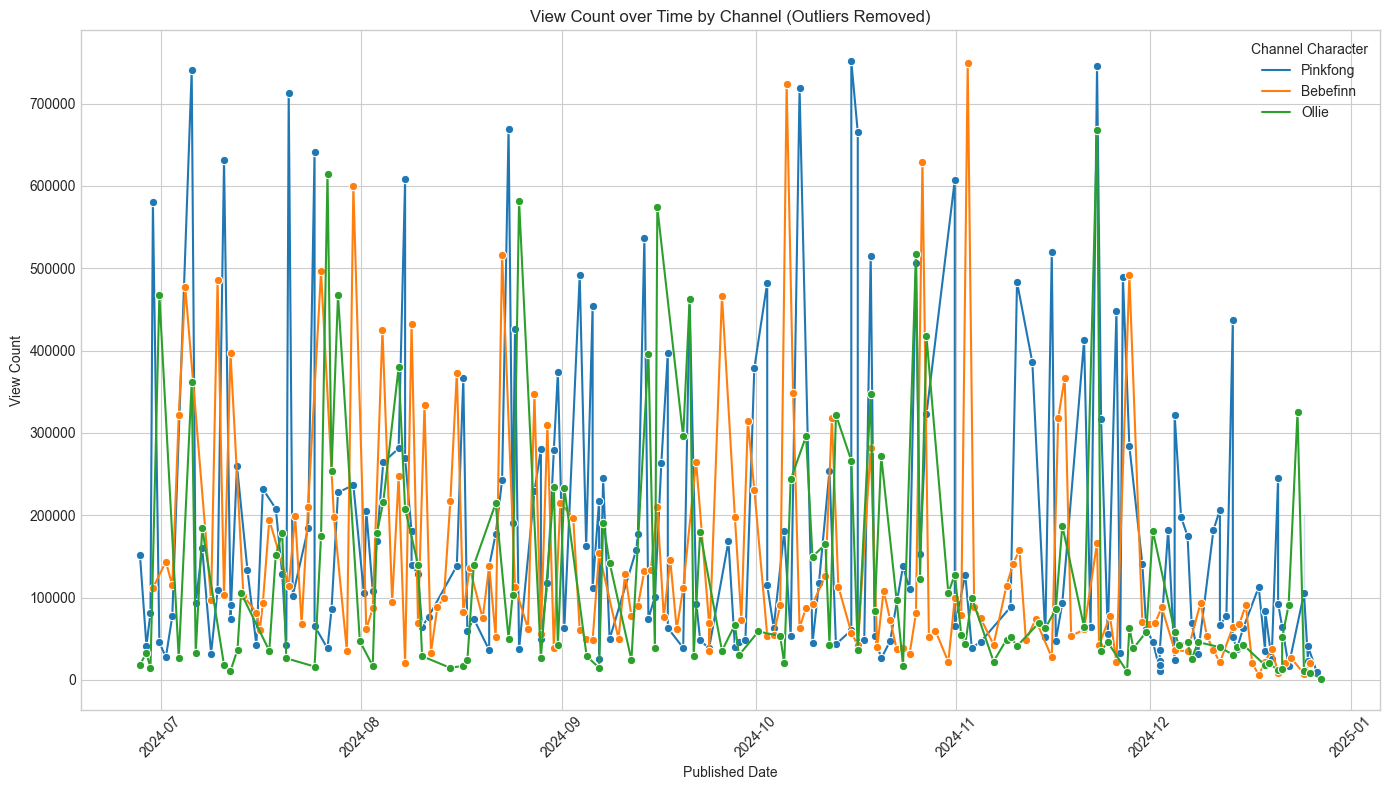

In [140]:
# Calculate the latest date in the dataset
latest_date = df_temporal_trends['published_at'].max()

# Calculate the date 6 months before the latest date
six_months_ago = latest_date - pd.DateOffset(months=6)

# Filter the dataframe to include only rows from the past 6 months
df_filtered_6months = df_temporal_trends[df_temporal_trends['published_at'] >= six_months_ago]

# Filter out the rows that have 'view_count' outside the bounds
df_filtered = remove_outlier_iqr(df_filtered_6months, ['view_count'])

# Create the line plot with the filtered data
plt.figure(figsize=(14, 8))
sns.lineplot(data=df_filtered, x='published_at', y='view_count', hue='channel_character', marker='o')

# Customize plot
plt.title('View Count over Time by Channel (Outliers Removed)')
plt.xlabel('Published Date')
plt.ylabel('View Count')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.legend(title='Channel Character')

# Show plot
plt.tight_layout()
plt.show()


Heat maps of video upload times by day and hour per channel.

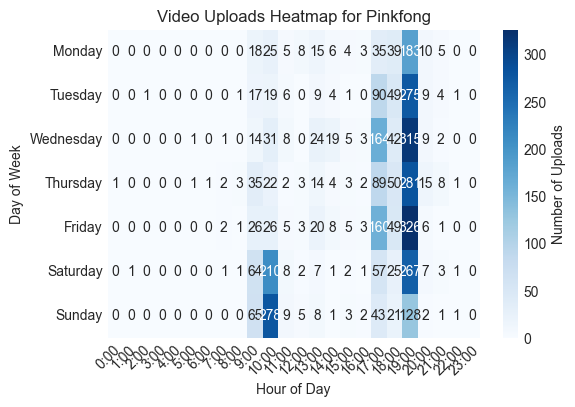

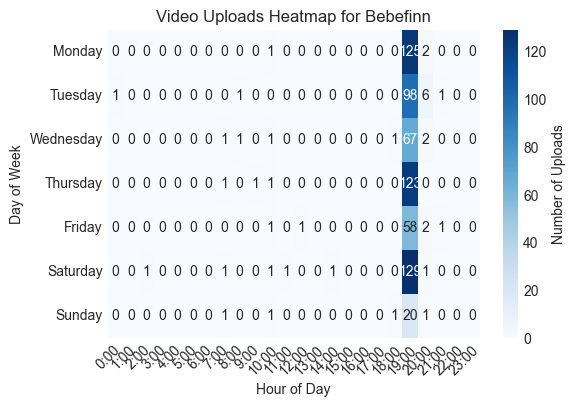

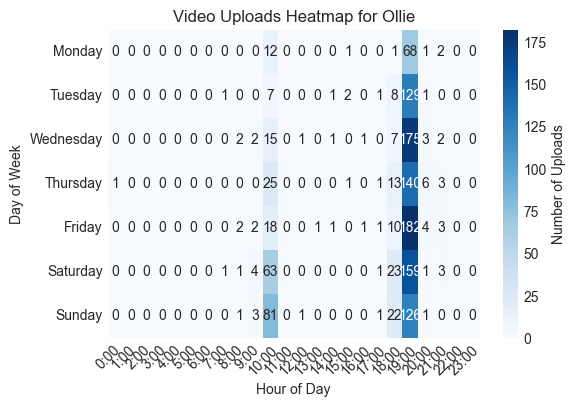

In [141]:
# Extract the hour and day of the week
df_temporal_trends['hour'] = pd.to_datetime(df_temporal_trends['published_at']).dt.hour
df_temporal_trends['day_of_week'] = pd.to_datetime(df_temporal_trends['published_at']).dt.day_name()  # 0=Monday, 6=Sunday

# Correct order of the days from Monday to Sunday
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert day of week to categorical to reorder
df_temporal_trends['day_of_week'] = pd.Categorical(df_temporal_trends['day_of_week'], categories=weekday_order, ordered=True)

# Group by channel_character, day_of_week, and hour, and count the uploads (i.e., number of records)
grouped = (
    df_temporal_trends.groupby(['channel_character', 'day_of_week', 'hour'])
    .size()  # Count number of uploads (records)
    .reset_index(name='upload_count')
)

# Create a complete grid of all possible day_name and hour combinations
all_combinations = pd.MultiIndex.from_product(
    [df_temporal_trends['channel_character'].unique(), weekday_order, range(24)],
    names=['channel_character', 'day_of_week', 'hour']
)

# Reindex the grouped data to include all possible combinations and fill missing with 0
grouped_full = grouped.set_index(['channel_character', 'day_of_week', 'hour']).reindex(all_combinations, fill_value=0).reset_index()

# Reorder the day_of_week column to ensure proper sorting for the heatmap
grouped_full['day_of_week'] = pd.Categorical(grouped_full['day_of_week'], categories=weekday_order, ordered=True)

# Create a heatmap for each channel_character
for channel in df_temporal_trends['channel_character'].unique():
    # Filter data for the current channel
    channel_data = grouped_full[grouped_full['channel_character'] == channel]
    
    # Pivot data to create a matrix for the heatmap
    pivot_table = channel_data.pivot(index='day_of_week', columns='hour', values='upload_count')
    
    # Plot the heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(pivot_table, cmap='Blues', annot=True, fmt=".0f", cbar_kws={'label': 'Number of Uploads'})
    plt.title(f"Video Uploads Heatmap for {channel}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Day of Week")
    plt.xticks(ticks=range(24), labels=[f"{i}:00" for i in range(24)], rotation=45)
    plt.yticks(rotation=0)  # Ensure day names appear horizontal
    plt.show()
    plt.close()  # Close the current plot before moving to the next one

Heat maps of video views by day and hour per channel.

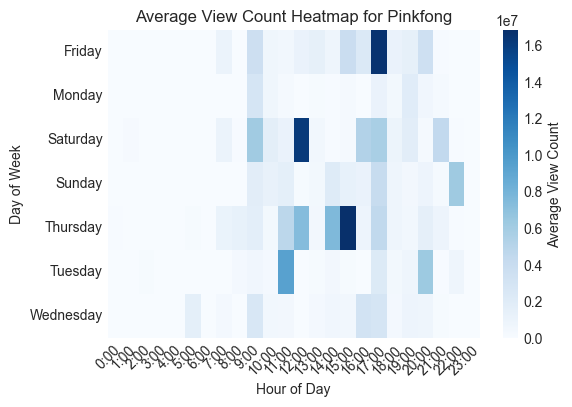

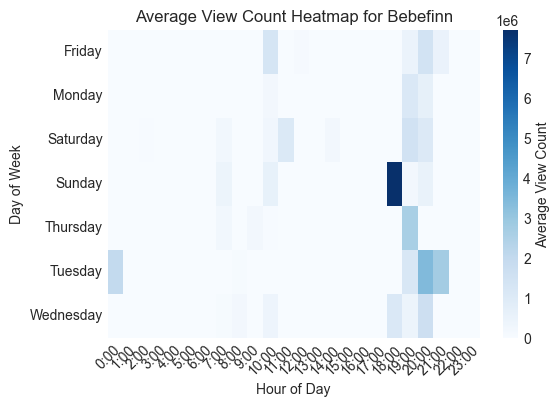

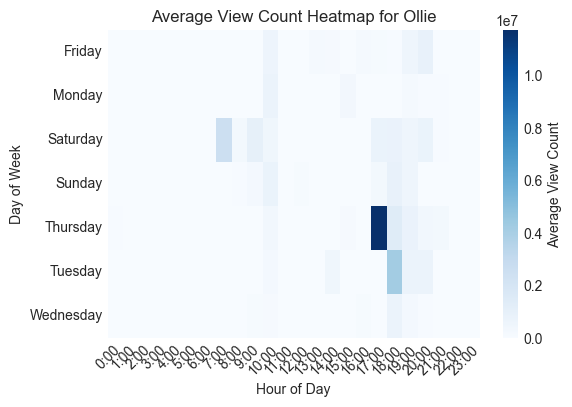

In [142]:
# Extract the hour and day of the week
df_temporal_trends['hour'] = pd.to_datetime(df_temporal_trends['published_at']).dt.hour
df_temporal_trends['day_of_week'] = pd.to_datetime(df_temporal_trends['published_at']).dt.day_name()  # 0=Monday, 6=Sunday

# Correct order of the days from Monday to Sunday
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Convert day of week to categorical to reorder
df_temporal_trends['day_of_week'] = pd.Categorical(df_temporal_trends['day_of_week'], categories=weekday_order, ordered=True)

# Group by channel_character, day_name, and hour, and calculate the average view_count
grouped = (
    df_temporal_trends.groupby(['channel_character', 'day_of_week', 'hour'])['view_count']
    .mean()
    .reset_index()
)

# Create a complete grid of all possible day_name and hour combinations
all_combinations = pd.MultiIndex.from_product(
    [df_temporal_trends['channel_character'].unique(), weekday_order, range(24)],
    names=['channel_character', 'day_of_week', 'hour']
)

# Reindex the grouped data to include all possible combinations and fill missing with 0
grouped_full = grouped.set_index(['channel_character', 'day_of_week', 'hour']).reindex(all_combinations, fill_value=0).reset_index()

# Create a heatmap for each channel_character
for channel in df_temporal_trends['channel_character'].unique():
    # Filter data for the current channel
    channel_data = grouped_full[grouped_full['channel_character'] == channel]
    
    # Pivot data to create a matrix for the heatmap
    pivot_table = channel_data.pivot(index='day_of_week', columns='hour', values='view_count').fillna(0)
    
    # Plot the heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(pivot_table, cmap='Blues', annot=False, fmt=".0f", cbar_kws={'label': 'Average View Count'})
    plt.title(f"Average View Count Heatmap for {channel}")
    plt.xlabel("Hour of Day")
    plt.ylabel("Day of Week")
    plt.xticks(ticks=range(24), labels=[f"{i}:00" for i in range(24)], rotation=45)
    plt.yticks(rotation=0)  # Ensure day names appear horizontal
    plt.show()
    plt.close()  # Close the current plot before moving to the next one

#### Observations: Temporal Trends

Last 6 months trend of video views over time:
- All channels seem to have a random pattern of views. This means that there is no clear trend in terms of views over time. That is why there should be a lot of testing to try and maximize views.
- However, that's why it would be better to compare the lowest points and with the eyes, Bebefinn seems to have a higher floor than the other two channels.

Upload Days:
- Pinkfong is mostly uploaded on Wednesday and Friday or Weekends
- Ollie is mostly uploaded on Wednesday and Friday
- Bebefinn is mostly uploaded on Monday, Thursday, Saturday

Upload Times:
- Pinkfong is mostly uploaded at 9~10 and 17~19
- Ollie is mostly uploaded at 10 and 19
- Bebefinn is mostly uploaded at 19

It seems like some time between 7 and 10 is also another time that could be possibly targeted. 
Even though it is not a lot but for all three channels' heatmaps it is seen that there is a slight peak at 8~10.

### Video Length Trends

In [143]:
df_video_length = df.copy()
df_video_length = df_video_length[['channel_character', 'duration', 'view_count']]
df_video_length.head(5)

,channel_character,duration,view_count
0,Pinkfong,128.883333,9152
1,Pinkfong,0.166667,40776
2,Pinkfong,180.216667,23468
3,Pinkfong,26.750000,8974
4,Pinkfong,0.266667,201126


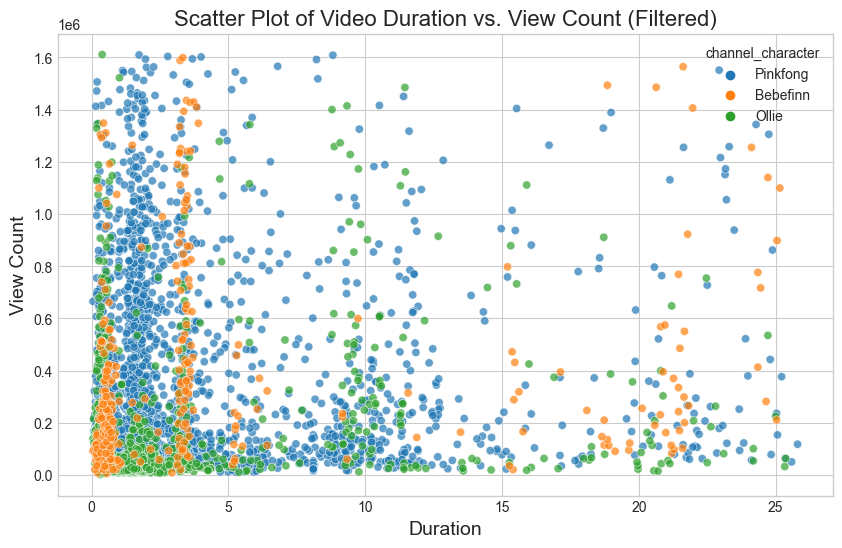

In [144]:
# Filter outliers
df_video_length = remove_outlier_iqr(df_video_length, ['duration', 'view_count'])

# Plot the filtered data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_video_length, x='duration', y='view_count', hue='channel_character', alpha=0.7)
plt.title("Scatter Plot of Video Duration vs. View Count (Filtered)", fontsize=16)
plt.xlabel("Duration", fontsize=14)
plt.ylabel("View Count", fontsize=14)
plt.show()

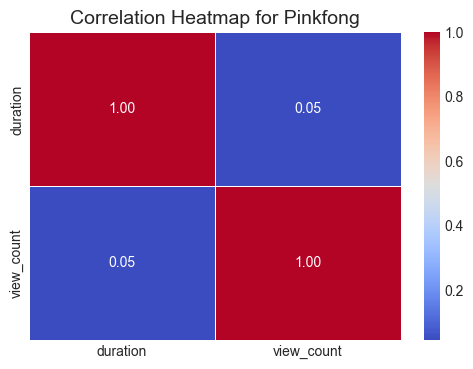

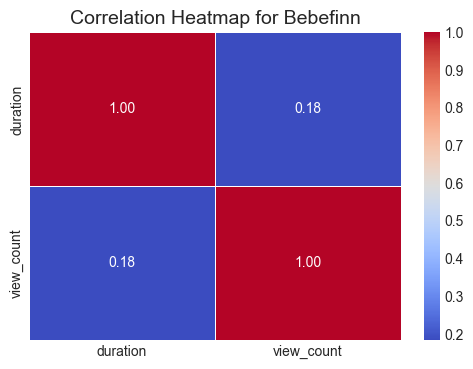

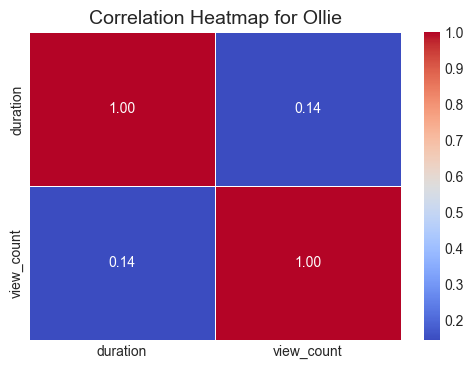

In [145]:
# Loop through each unique channel_character
for channel in df_video_length['channel_character'].unique():
    # Filter the data for the current channel_character
    channel_data = df_video_length[df_video_length['channel_character'] == channel]
    
    # Calculate the correlation matrix for 'duration' and 'view_count'
    correlation_matrix = channel_data[['duration', 'view_count']].corr()
    
    # Plot the heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
    plt.title(f"Correlation Heatmap for {channel}", fontsize=14)
    plt.show()

#### Observations: Video Length Trends

Even after removing the outliers it is seen that other than Bebefinn, there is no clear correlation between duration of the video and view_count.

## Comparative Analysis

### Category Performance

In [146]:
df_category_performance = df.copy()
df_category_performance = df_category_performance[['channel_character', 'category_name', 'view_count']]
df_category_performance.head(5)

,channel_character,category_name,view_count
0,Pinkfong,Education,9152
1,Pinkfong,Education,40776
2,Pinkfong,Education,23468
3,Pinkfong,Education,8974
4,Pinkfong,Education,201126


First visualize the different categories for each channel with bar plots.

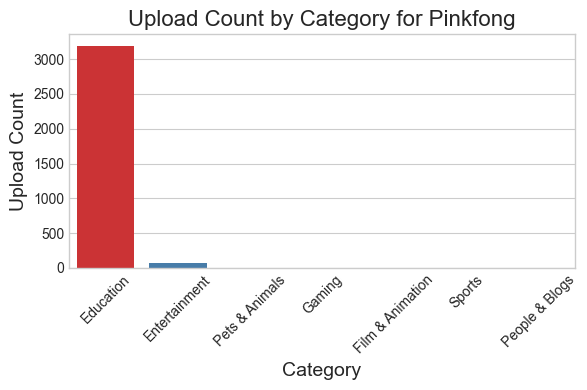

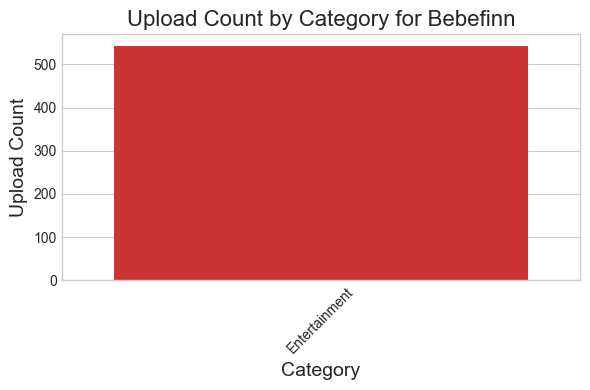

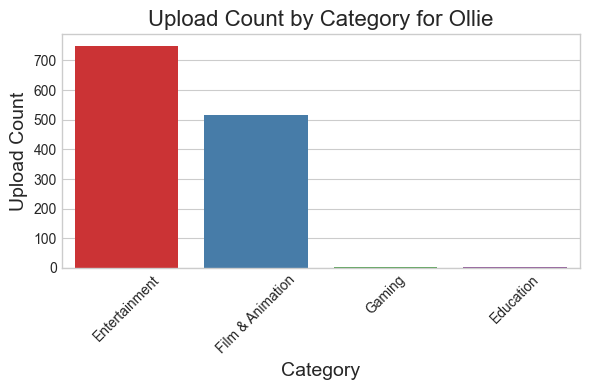

In [155]:
# Loop through each unique channel_character
for channel in df_video_length['channel_character'].unique():
    # Filter the data for the current channel_character
    channel_data = df_category_performance[df_category_performance['channel_character'] == channel]
    
    # Get the values for the bar plot
    value_counts = channel_data['category_name'].value_counts()
    
    # Plot upload count by category_name
    plt.figure(figsize=(6, 4))
    sns.barplot(data=channel_data, x=value_counts.index, y=value_counts.values, palette='Set1')
    plt.title(f"Upload Count by Category for {channel}", fontsize=16)
    plt.xlabel("Category", fontsize=14)
    plt.ylabel("Upload Count", fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

The bar plots show that Pinkfong has uploaded videos in various categories while for Ollie there is less variation. Bebefinn will be excluded from this analysis because it only has one category.

Now visualize the view rate of each category. Only for Pinkfong and Ollie.

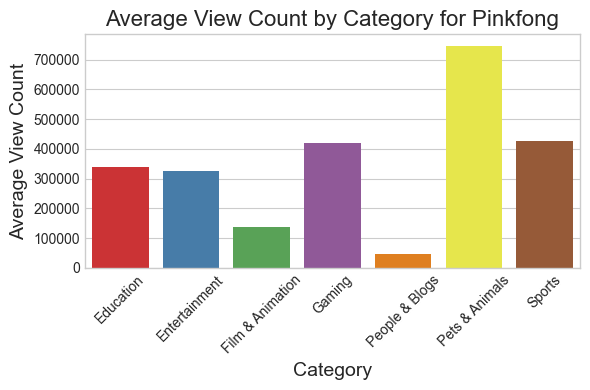

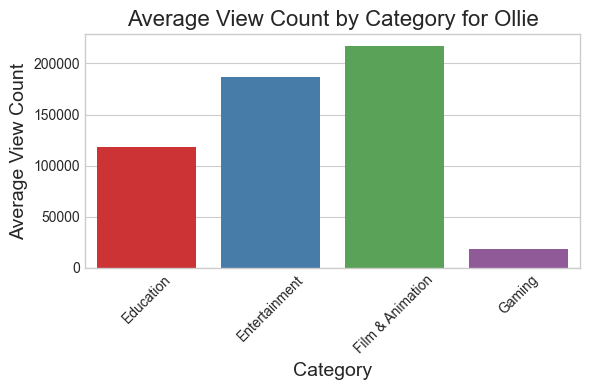

In [148]:
df_category_performance = remove_outlier_iqr(df_category_performance, ['view_count'])

# Loop through each unique channel_character
for channel in ['Pinkfong', 'Ollie']:
    # Filter the data for the current channel_character and calculate the average view count
    channel_data = (
        df_category_performance[df_category_performance['channel_character'] == channel]
        .groupby('category_name', as_index=False)['view_count'].mean()
    )
    
    # Plot average view_count by category_name
    plt.figure(figsize=(6, 4))
    sns.barplot(data=channel_data, x='category_name', y='view_count', palette='Set1')
    plt.title(f"Average View Count by Category for {channel}", fontsize=16)
    plt.xlabel("Category", fontsize=14)
    plt.ylabel("Average View Count", fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### Observations: Category Performance

Although there is a huge imbalance in the amount of videos in the different categories, there seems not to be a big difference in the average views per video between the categories. That is why the category performance should be delved deeper through hypothesis testing. Through these, the priorities for the categories could be determined, specially for Bebefinn, which has only one category.

### Title Length Performance

In [149]:
df_title_length = df.copy()
df_title_length = df_title_length[['channel_character', 'title', 'view_count']]
df_title_length.head(5)

,channel_character,title,view_count
0,Pinkfong,[BEST🏆] 언제 어디서나! 가족과 함께 듣는 핑크퐁 인기 동요 메들리🎶 | +모...,9152
1,Pinkfong,종소리 울려라~🔔 오늘은 크리스마스에요! #크리스마스 #핑크퐁,40776
2,Pinkfong,[TV📺] 울면 안 돼~ 오늘은 크리스마스에요! | 핑크퐁 아기상어 BEST 캐럴 ...,23468
3,Pinkfong,[크리스마스 스페셜] 인기 크리스마스 동화 모음 | 재미있는 동화책 읽어요 📖 | ...,8974
4,Pinkfong,크리스마스에 상어 산타를 만난다면?🎅 #크리스마스 #핑크퐁,201126


First create a column for the length of the titles and then filter the outliers with IQR.

In [150]:
# Create a column for the length of the titles
df_title_length['title_length'] = df_title_length['title'].str.len()

# Remove outliers for view_count using IQR method
df_title_length = remove_outlier_iqr(df_title_length, ['view_count'])

Visualize the length of the titles and view count with a scatter plot.

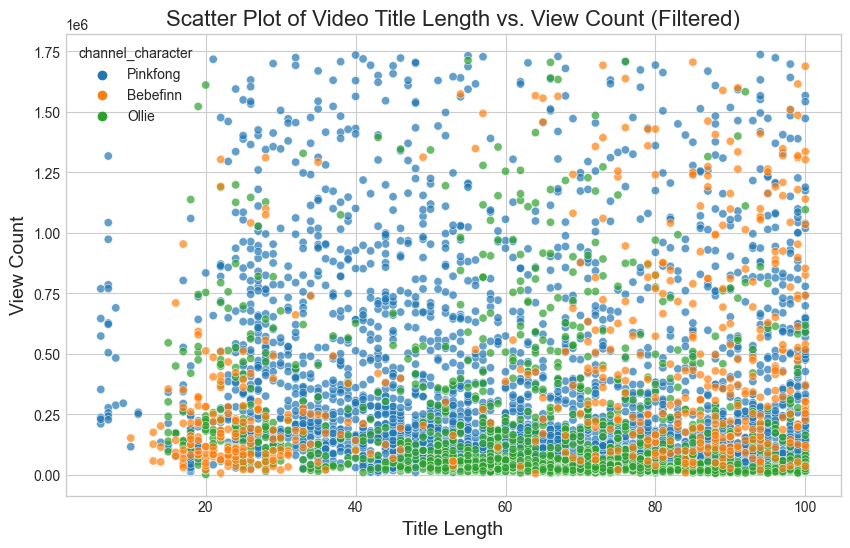

In [151]:
# Plot the filtered data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_title_length, x='title_length', y='view_count', hue='channel_character', alpha=0.7)
plt.title("Scatter Plot of Video Title Length vs. View Count (Filtered)", fontsize=16)
plt.xlabel("Title Length", fontsize=14)
plt.ylabel("View Count", fontsize=14)
plt.show()

Visualize a heatmap to see the relationship between the title length and view count. The scatter plot above doesn't look so clear.

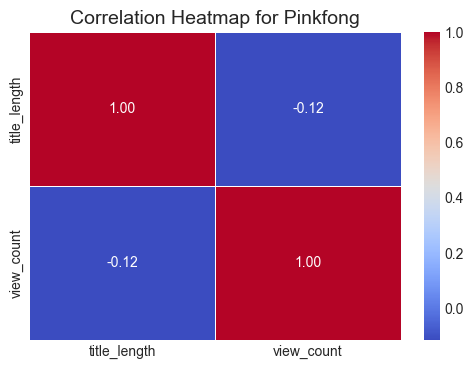

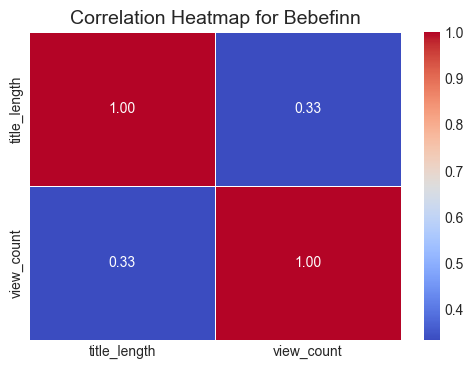

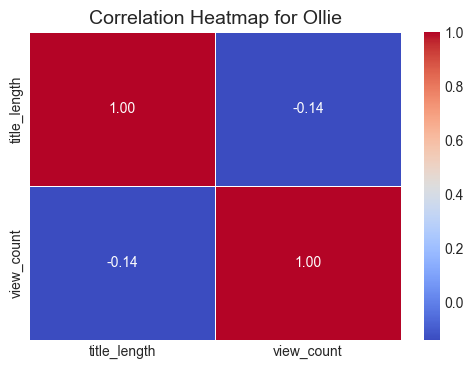

In [152]:
# Loop through each unique channel_character
for channel in df_title_length['channel_character'].unique():
    # Filter the data for the current channel_character
    channel_data = df_title_length[df_title_length['channel_character'] == channel]
    
    # Calculate the correlation matrix for 'title_length' and 'view_count'
    correlation_matrix = channel_data[['title_length', 'view_count']].corr()
    
    # Plot the heatmap
    plt.figure(figsize=(6, 4))
    sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt='.2f', linewidths=0.5)
    plt.title(f"Correlation Heatmap for {channel}", fontsize=14)
    plt.show()

#### Observations: Title Length Performance

There doesn't seem to be a strong correlation between the title length and view count. However, for Bebefinn there seems to be a difference. This could be tested through hypothesis testing.

# Save cleaned dataset

Save the cleaned dataset to a new CSV file, to be used in the hypothesis testing notebook.

In [154]:
df.to_csv('../data/processed/hypothesis_testing.csv', header=True, index=False)